In [ ]:
!pip install -q datasets transformers accelerate scikit-learn

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch

In [ ]:
import os, psutil
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
print("RAM (GB):", psutil.virtual_memory().total / 1e9)

GPU available: True
GPU name: Tesla T4
RAM (GB): 13.605851136


In [ ]:
dataset = load_dataset("nyu-mll/glue", "mnli")  # mnli: premise, hypothesis, label [web:25]
print(dataset)

print("Satu contoh train:")
print(dataset["train"][0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mnli/train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

mnli/validation_matched-00000-of-00001.p(…):   0%|          | 0.00/1.21M [00:00<?, ?B/s]

mnli/validation_mismatched-00000-of-0000(…):   0%|          | 0.00/1.25M [00:00<?, ?B/s]

mnli/test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

mnli/test_mismatched-00000-of-00001.parq(…):   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
Satu contoh train:
{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.', 'hypothesis': 'Product and geography are what make cream skimming work. ', 'label': 1, 'idx': 0}


In [ ]:
# 3. Tokenizer & model
model_name = "bert-base-uncased"  # bisa diganti "distilbert-base-uncased" kalau mau lebih ringan
# Nama model pretrained dari HuggingFace Hub (BERT full size, huruf lowercase)
# Alternatif: DistilBERT lebih ringan & cepat tapi sedikit kurang akurat
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load tokenizer yang sesuai dengan model BERT (otomatis cocok dengan architecture model)

num_labels = 3  # entailment, neutral, contradiction
# Jumlah kelas untuk NLI (Natural Language Inference):
#   - 0: entailment (premise menyebabkan hypothesis)
#   - 1: neutral (tidak ada hubungan)
#   - 2: contradiction (premise bertentangan dengan hypothesis)


model = AutoModelForSequenceClassification.from_pretrained(
    model_name,                                             # Nama model BERT yang akan di-load
    num_labels=num_labels,                                  # Set jumlah neuron output = 3 (untuk 3 kelas NLI)
)
# Load model pretrained BERT yang sudah dimodifikasi untuk tugas klasifikasi 3 kelas

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 4. Preprocessing: tokenisasi pasangan premise & hypothesis
def preprocess_function(batch):                             # Fungsi untuk preprocessing satu batch contoh data
    return tokenizer(                                       # Tokenisasi dengan tokenizer BERT
        batch["premise"],                                   # Teks pertama: kalimat premise (pernyataan awal)
        batch["hypothesis"],                                # Teks kedua: kalimat hypothesis (hipotesis/pernyataan banding)
        truncation=True,                                    # Potong pasangan teks jika total panjangnya > max_length
        padding=False,                                      # Tidak padding di sini (padding dilakukan nanti di DataCollator)
        max_length=128,                                     # Panjang maksimum total untuk kedua teks kombinasi
    )
# Tokenizer BERT otomatis menangani dua teks sekaligus dengan separator token [SEP]

print("Tokenisasi dataset (butuh waktu)...")
encoded = dataset.map(preprocess_function, batched=True)    # Terapkan fungsi preprocess ke seluruh dataset secara batch
# Hasilnya: dataset berisi kolom input_ids, attention_mask, token_type_ids (plus kolom lain yang asli)

Tokenisasi dataset (butuh waktu)...


Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [ ]:
# 5. Siapkan kolom labels dan buang kolom tak perlu
for split in encoded.keys():                                # Loop setiap split dataset (train, validation, test)
    encoded[split] = encoded[split].rename_column("label", "labels")
# Ubah nama kolom 'label' menjadi 'labels' (sesuai konvensi HuggingFace Trainer)

cols_to_keep = ["input_ids", "attention_mask", "labels"]    # Daftar kolom yang ingin dipertahankan
for split in encoded.keys():                                # Loop setiap split dataset
    encoded[split] = encoded[split].remove_columns(         # Hapus kolom-kolom yang tidak perlu
        [c for c in encoded[split].column_names if c not in cols_to_keep]
        # List comprehension: ambil semua nama kolom, pilih yang TIDAK ada di cols_to_keep
    )
# Hasil: hanya tinggal kolom input_ids, attention_mask, labels

for split in encoded.keys():                                # Loop setiap split dataset
    encoded[split].set_format(type="torch", columns=cols_to_keep)
# Set format output dataset jadi tensor PyTorch untuk kolom-kolom tertentu

print(encoded)                                              # Cetak ringkasan struktur dataset setelah pembersihan

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 9847
    })
})


In [ ]:
# 6. Data collator (padding dinamis)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# 7. compute_metrics
label_names = ["entailment", "neutral", "contradiction"]  # sesuai README MNLI
# Nama-nama kelas untuk NLI:
#   - entailment: premise logis menghasilkan hypothesis
#   - neutral: tidak ada hubungan logis antara premise dan hypothesis
#   - contradiction: premise bertentangan dengan hypothesis

def compute_metrics(eval_pred):                             # Fungsi untuk menghitung metrik saat evaluasi
    logits, labels = eval_pred                              # Unpacking: logits (skor mentah) dan labels (target)
    preds = np.argmax(logits, axis=-1)                      # Ambil kelas prediksi dengan logit terbesar per sample
    acc      = accuracy_score(labels, preds)                # Hitung accuracy: persentase prediksi yang benar
    f1_micro = f1_score(labels, preds, average="micro")     # Hitung F1-score micro: global TP/FP/FN di semua kelas
    f1_macro = f1_score(labels, preds, average="macro")     # Hitung F1-score macro: rata F1 per kelas (bobot sama tiap kelas)
    return {                                                # Kembalikan dictionary berisi semua metrik
        "accuracy": acc,                                    # Akurasi keseluruhan
        "f1_micro": f1_micro,                               # F1 micro (performa global)
        "f1_macro": f1_macro,                               # F1 macro (performa rata per kelas)
    }

In [ ]:
# 8. Pilih split train & eval
train_dataset = encoded["train"]
eval_dataset  = encoded["validation_matched"]

print("Jumlah contoh train:", len(train_dataset))
print("Jumlah contoh eval :", len(eval_dataset))


Jumlah contoh train: 392702
Jumlah contoh eval : 9815


In [ ]:
batch_size = 16                                              # Ukuran batch untuk training dan evaluasi (16 contoh per batch)

training_args = TrainingArguments(                           # Objek pengaturan untuk proses training dengan Trainer
    output_dir="./mnli-bert-base",                           # Folder untuk menyimpan checkpoint dan model hasil training
    eval_strategy="epoch",                                   # (Seharusnya 'evaluation_strategy') evaluasi dilakukan setiap epoch
    save_strategy="epoch",                                   # Simpan checkpoint model di akhir setiap epoch
    learning_rate=2e-5,                                      # Learning rate untuk optimizer (kecepatan update bobot)
    per_device_train_batch_size=batch_size,                  # Batch size per device (GPU/CPU) saat training
    per_device_eval_batch_size=batch_size,                   # Batch size per device saat evaluasi
    num_train_epochs=3,                                      # Jumlah epoch (berapa kali seluruh data training dilalui)
    weight_decay=0.01,                                       # Weight decay (regularisasi L2) untuk mencegah overfitting
    load_best_model_at_end=True,                             # Setelah training selesai, muat model terbaik berdasarkan metric
    metric_for_best_model="accuracy",                        # Metrik acuan untuk memilih model terbaik adalah accuracy
    logging_steps=200,                                       # Tulis log training setiap 200 training step
    report_to="none",                                        # Jangan report hasil ke WandB atau platform tracking lain (hanya local)
)

In [ ]:
# 10. Trainer
trainer = Trainer(                                           # Inisialisasi HuggingFace Trainer untuk training & evaluasi
    model=model,                                             # Model BERT yang sudah diset untuk klasifikasi 3 kelas NLI
    args=training_args,                                      # Objek TrainingArguments (lr, epoch, batch_size, logging, dsb.)
    train_dataset=train_dataset,                             # Dataset training yang sudah di-tokenisasi dan di-format
    eval_dataset=eval_dataset,                               # Dataset evaluasi (validation) untuk menghitung metrik tiap epoch
    tokenizer=tokenizer,                                     # Tokenizer BERT (untuk padding/truncation saat batching)
    data_collator=data_collator,                             # DataCollatorWithPadding untuk buat batch dengan padding dinamis
    compute_metrics=compute_metrics,                         # Fungsi custom untuk hitung metrik (accuracy, F1 micro, F1 macro)
)

/tmp/ipython-input-1399196390.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 11. Training
train_result = trainer.train()
trainer.save_model("./mnli-bert-base-best")

print("Hasil training:")
print(train_result)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro
1,0.475400,0.444855,0.829241,0.829241,0.828984
2,0.338200,0.467493,0.836780,0.836780,0.836457
3,0.233600,0.569858,0.841365,0.841365,0.840857


Hasil training:
TrainOutput(global_step=73632, training_loss=0.36962296176816734, metrics={'train_runtime': 17354.8303, 'train_samples_per_second': 67.883, 'train_steps_per_second': 4.243, 'total_flos': 4.80260438319128e+16, 'train_loss': 0.36962296176816734, 'epoch': 3.0})


In [ ]:
id2label = {0: "entailment", 1: "neutral", 2: "contradiction"}  # Mapping dari ID kelas ke nama label manusiawi
model.eval()                                                # Set model ke mode evaluasi (non-training: matikan dropout, dsb.)
examples = [                                                # Daftar contoh pasangan (premise, hypothesis) untuk diuji
    ("A man is playing a guitar.", "A person is making music."),      # Contoh: entailment (sama artinya)
    ("A man is playing a guitar.", "No one is playing music."),       # Contoh: contradiction (bertentangan)
]

for prem, hypo in examples:                                 # Loop setiap pasangan premise & hypothesis
    enc = tokenizer(                                        # Tokenisasi pasangan teks
        prem,                                               # Teks pertama: premise
        hypo,                                               # Teks kedua: hypothesis
        return_tensors="pt",                                # Kembalikan hasil sebagai tensor PyTorch
        truncation=True,                                    # Potong jika terlalu panjang
        padding=True                                        # Padding otomatis
    ).to(model.device)                                      # Pindahkan ke device yang sama dengan model (GPU/CPU)

    with torch.no_grad():                                   # Blok tanpa gradien (hemat memori, lebih cepat untuk inference)
        outputs = model(**enc)                              # Jalankan forward pass model dengan input yang sudah di-tokenisasi
        pred_id = torch.argmax(outputs.logits, dim=-1).item()
        # Ambil ID kelas dengan logit terbesar (prediction), konversi ke Python int dengan .item()

    print("Premise   :", prem)                              # Cetak kalimat premise
    print("Hypothesis:", hypo)                              # Cetak kalimat hypothesis
    print("Prediction:", id2label[pred_id])                 # Cetak hasil prediksi dengan nama label yang terbaca
    print("-" * 40)                                         # Cetak garis pemisah antar contoh

Premise   : A man is playing a guitar.
Hypothesis: A person is making music.
Prediction: entailment
----------------------------------------
Premise   : A man is playing a guitar.
Hypothesis: No one is playing music.
Prediction: contradiction
----------------------------------------


In [ ]:
import matplotlib.pyplot as plt                              # Import matplotlib untuk membuat visualisasi/plot

log_history = trainer.state.log_history                      # Ambil riwayat log dari Trainer (list of dict)
# Berisi log training step (loss) dan evaluasi (eval_loss, eval_accuracy) setiap epoch

steps = []                                                   # List untuk menyimpan nomor step
train_loss_values = []                                       # List untuk menyimpan nilai training loss
val_loss_values = []                                         # List untuk menyimpan nilai validation loss
val_acc_values = []                                          # List untuk menyimpan nilai validation accuracy

for log in log_history:                                      # Loop setiap entry dalam log history
    # training loss (biasanya punya key 'loss' dan 'step')
    if 'loss' in log and 'step' in log:                      # Jika entry ini adalah log training (punya 'loss' dan 'step')
        steps.append(log['step'])                            # Tambahkan nomor step
        train_loss_values.append(log['loss'])                # Tambahkan nilai training loss
    # eval metrics (validation)
    if 'eval_loss' in log and 'eval_accuracy' in log:        # Jika entry ini adalah log evaluasi (punya 'eval_loss' dan 'eval_accuracy')
        # pakai step yang sama atau eval_step jika ada
        step = log.get('step', log.get('eval_step', None))
        # Coba ambil 'step', kalau tidak ada coba 'eval_step', kalau juga tidak ada jadi None
        if step is not None:                                 # Jika ada step yang valid
            # pastikan tidak dobel; opsional bisa pakai list terpisah
            val_loss_values.append(log['eval_loss'])         # Tambahkan nilai validation loss
            val_acc_values.append(log['eval_accuracy'])      # Tambahkan nilai validation accuracy

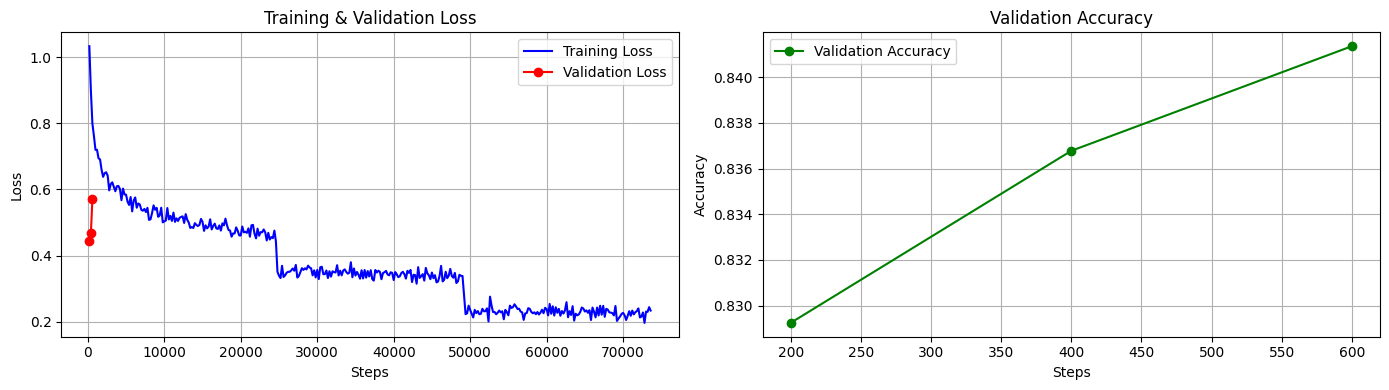

In [ ]:
plt.figure(figsize=(14, 4))                                  # Buat figure baru dengan ukuran 14x4 inch

# Plot 1: Training & Validation Loss
plt.subplot(1, 2, 1)                                         # Subplot pertama (kiri) dari 1 baris 2 kolom
plt.plot(steps[:len(train_loss_values)], train_loss_values,  # Plot garis training loss
         color='blue', label='Training Loss')                # Warna biru, label "Training Loss"
plt.plot(steps[:len(val_loss_values)], val_loss_values,      # Plot garis validation loss
         color='red', marker='o', label='Validation Loss')   # Warna merah, marker bulat, label "Validation Loss"
plt.title('Training & Validation Loss')                      # Judul plot
plt.xlabel('Steps')                                          # Label sumbu-x
plt.ylabel('Loss')                                           # Label sumbu-y
plt.legend()                                                 # Tampilkan legenda
plt.grid(True)                                               # Tampilkan grid untuk mempermudah pembacaan

# Plot 2: Validation Accuracy
plt.subplot(1, 2, 2)                                         # Subplot kedua (kanan) dari 1 baris 2 kolom
plt.plot(steps[:len(val_acc_values)], val_acc_values,        # Plot garis validation accuracy
         color='green', marker='o', label='Validation Accuracy')  # Warna hijau, marker bulat, label "Validation Accuracy"
plt.title('Validation Accuracy')                             # Judul plot
plt.xlabel('Steps')                                          # Label sumbu-x
plt.ylabel('Accuracy')                                       # Label sumbu-y
plt.grid(True)                                               # Tampilkan grid
plt.legend()                                                 # Tampilkan legenda

plt.tight_layout()                                           # Atur layout agar subplot tidak saling tumpang tindih
plt.show()                                                   # Tampilkan semua grafik di figure